In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
sys.path.append('../../../optimal-signal-demixing/')
from osd import Problem
from osd.components import (
    MeanSquareSmall, 
    TimeSmoothEntryClose, 
    LinearTrend
)
from osd.components.wrappers import make_columns_equal

In [3]:
T = 100
p = 5

lambda1 = 100
lambda2 = 10
weight = 1
rho = 1 
vavg = None
period = None
np.random.seed(42)
v_in = np.random.randn(T, p)
tsec = TimeSmoothEntryClose(lambda1=lambda1, lambda2=lambda2, vavg=vavg)
v_out = tsec.prox_op(v_in, weight, rho)

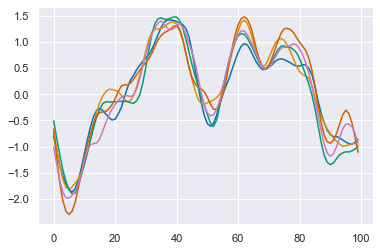

In [4]:
plt.plot(10 * v_out)

In [20]:
np.savetxt('vector_smooth_low_var.txt', 10 * v_out)

In [5]:
X1 = 0.15 * np.random.randn(T, p)
X2 = 10 * v_out
X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
X_real = np.array([X1, X2, X3])
y = np.sum(X_real, axis=0)

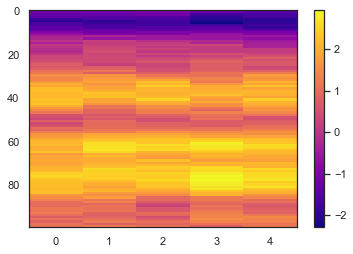

In [6]:
with sns.axes_style('white'):
    plt.imshow(y, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.show()

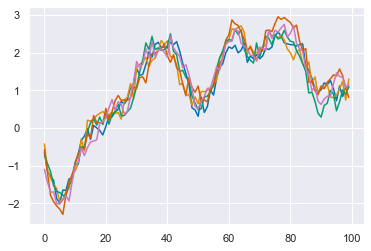

In [7]:
plt.plot(y)

In [65]:
def make_data():
    data_file_path = "vector_smooth_low_var.txt"
    with open(data_file_path) as file:
        data = np.loadtxt(file)
    T, p = data.shape
    np.random.seed(110100100)
    X1 = 0.15 * np.random.randn(T, p)
    X2 = data
    X3 = np.tile(np.linspace(0, 2, T), (p, 1)).T
    X_real = np.array([X1, X2, X3])
    y = np.sum(X_real, axis=0)
    use_set = np.random.uniform(size=v_in.shape) >= 0.25
    use_set[40:50] = False
    y[~use_set] = np.nan
    return y, X_real

In [66]:
import cvxpy as cvx
rms = lambda x: np.sqrt(np.average(np.power(x, 2)))

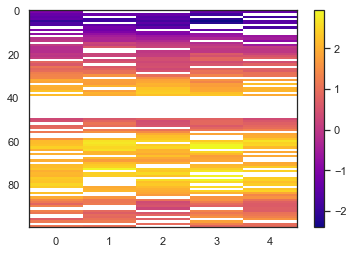

In [176]:
y, X_real = make_data()
with sns.axes_style('white'):
    plt.imshow(y, aspect='auto', interpolation='none', cmap='plasma')
    plt.colorbar()
    plt.show()

In [177]:
components = [
    MeanSquareSmall(size=y.size),
    TimeSmoothEntryClose(
        lambda1=1e3, lambda2=1e-2, weight=5e-3/y.size
    ),
    make_columns_equal(LinearTrend)(first_val=0),
]
problem = Problem(y, components=components)

In [178]:
problem.decompose(how='cvx', reset=True)

                                     CVXPY                                     
                                    v1.1.18                                    
(CVXPY) Jan 27 02:14:07 PM: Your problem has 1600 variables, 4 constraints, and 3 parameters.
(CVXPY) Jan 27 02:14:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 27 02:14:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jan 27 02:14:07 PM: Compiling problem (target solver=OSQP).
(CVXPY) Jan 27 02:14:07 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> OSQP
(CVXPY) Jan 27 02:14:07 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jan 27 02:14:07 PM: Applying reduction Qp2SymbolicQ

In [179]:
problem.objective_value

0.021172605064935457

In [180]:
rms(problem.estimates[0] - X_real[0])

0.10807170461721956

In [181]:
rms(problem.estimates[1] - X_real[1])

0.21565764852529223

In [182]:
rms(problem.estimates[2] - X_real[2])

0.14697537347115686

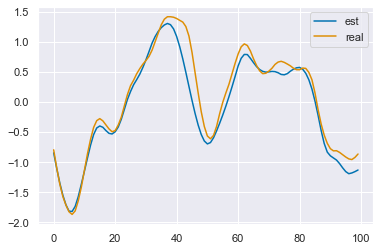

In [183]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

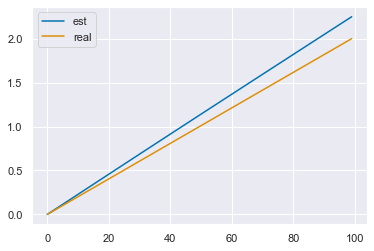

In [184]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

In [185]:
problem.decompose(how='admm', reset=True, stop_early=False)

[====================] ...79 iterations, 0.32 sec -- obj_val: 2.12e-02, r: 5.70e-06, tol: 1.01e-05      



In [186]:
problem.objective_value

0.02117264207101866

In [187]:
rms(problem.estimates[0] - X_real[0])

0.10807247232914902

In [188]:
rms(problem.estimates[1] - X_real[1])

0.613927824708092

In [189]:
rms(problem.estimates[2] - X_real[2])

0.6008257353525145

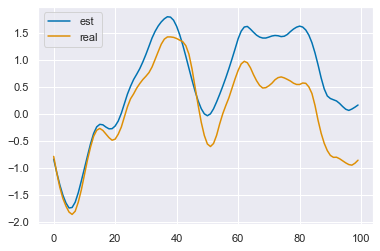

In [190]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

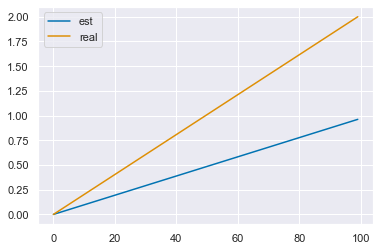

In [191]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

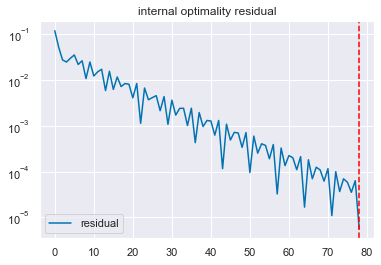

In [192]:
plt.figure()
plt.plot(problem.admm_result['optimality_residual'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')
plt.legend()
plt.title('internal optimality residual')
plt.show()

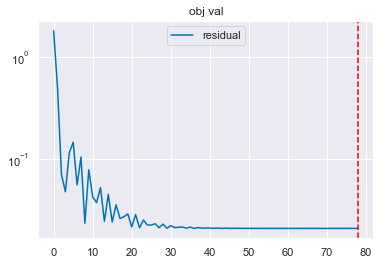

In [193]:
plt.figure()
plt.plot(problem.admm_result['obj_vals'], label='residual')
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.legend()
plt.title('obj val')
plt.yscale('log')
plt.show()

In [194]:
problem.decompose(how='bcd', reset=True)

Starting BCD...
y shape: (100, 5)
X shape: (3, 100, 5)



In [195]:
problem.objective_value

0.021173296606942067

In [196]:
rms(problem.estimates[0] - X_real[0])

0.10816359306873197

In [197]:
rms(problem.estimates[1] - X_real[1])

0.24445421254995545

In [198]:
rms(problem.estimates[2] - X_real[2])

0.19670067937790245

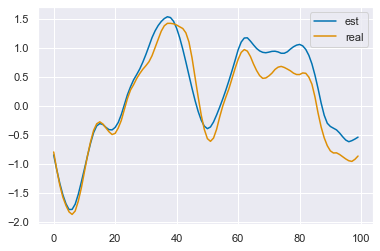

In [199]:
col = 0
comp = 1
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

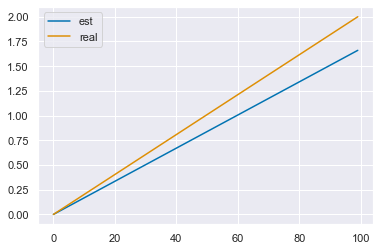

In [200]:
# col = 3
comp = 2
plt.plot(problem.estimates[comp, :, col], label='est')
plt.plot(X_real[comp, :, col], label='real')
plt.legend();

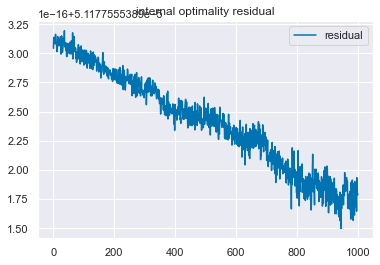

In [201]:

plt.figure()
plt.plot(problem.bcd_result['optimality_residual'], label='residual')
plt.legend()
plt.title('internal optimality residual')
plt.show()

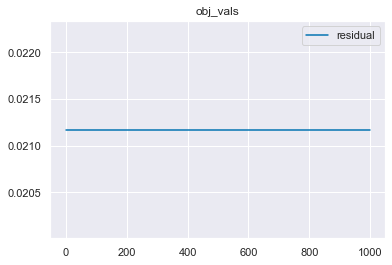

In [147]:
plt.figure()
plt.plot(problem.bcd_result['obj_vals'], label='residual')
plt.legend()
plt.title('obj_vals')
plt.show()

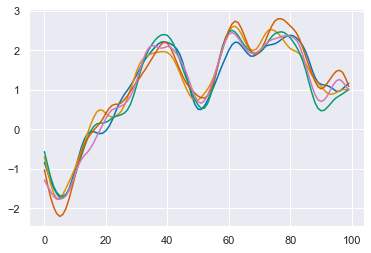

In [63]:
plt.plot(problem.estimates[1])

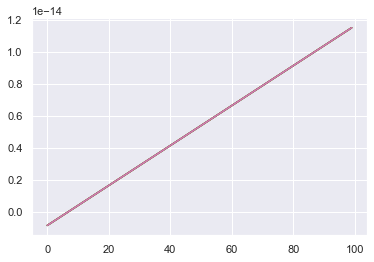

In [64]:
plt.plot(problem.estimates[2])